In [1]:
import arbitragelab.copula_approach.vinecop_generate as vinecop_generate
import arbitragelab.copula_approach.vinecop_strategy as vinecop_strategy
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

from arbitragelab.copula_approach.copula_calculation import to_quantile
# import arbitragelab.util.data_importer as data_importer

In [2]:
# Import data
sp500_prices = pd.read_csv('D://Apprenticeship//Hudson_Thames//prices_10y_SP500.csv',
                          index_col=0, parse_dates=True).fillna(method='ffill')
sp500_returns = sp500_prices.pct_change().fillna(0)

In [3]:
# Fit a C-vine copula
# Get stocks returns, train test split
subsample = sp500_returns[['AAPL', 'ABT', 'V', 'AIZ']]
returns_train = subsample.iloc[:800]
returns_test = subsample.iloc[800:1600]

# Fit the C-vine
quantiles, cdfs = to_quantile(returns_train)
cvinecop = vinecop_generate.CVineCop()
print(cvinecop.fit_auto(data=quantiles, pv_target_idx=1, if_renew=True))

<pyvinecopulib.Vinecop>
** Tree: 0
1,2 <-> Gumbel 180°, parameters = 1.15349
4,2 <-> Gaussian, parameters = 0.423463
3,2 <-> Gumbel 180°, parameters = 1.36267
** Tree: 1
1,3 | 2 <-> Frank, parameters = 1.88015
4,3 | 2 <-> Gumbel, parameters = 1.23514
** Tree: 2
1,4 | 2,2 <-> Frank, parameters = 0.956245



In [4]:
# Initiate the trading class
CVCS = vinecop_strategy.CVineCopStrat()
# Calculate MPIs for the trading period
mpis_trading = CVCS.calc_mpi(returns=returns_test, cdfs=cdfs, subtract_mean=True)
cmpis_trading = mpis_trading.cumsum()

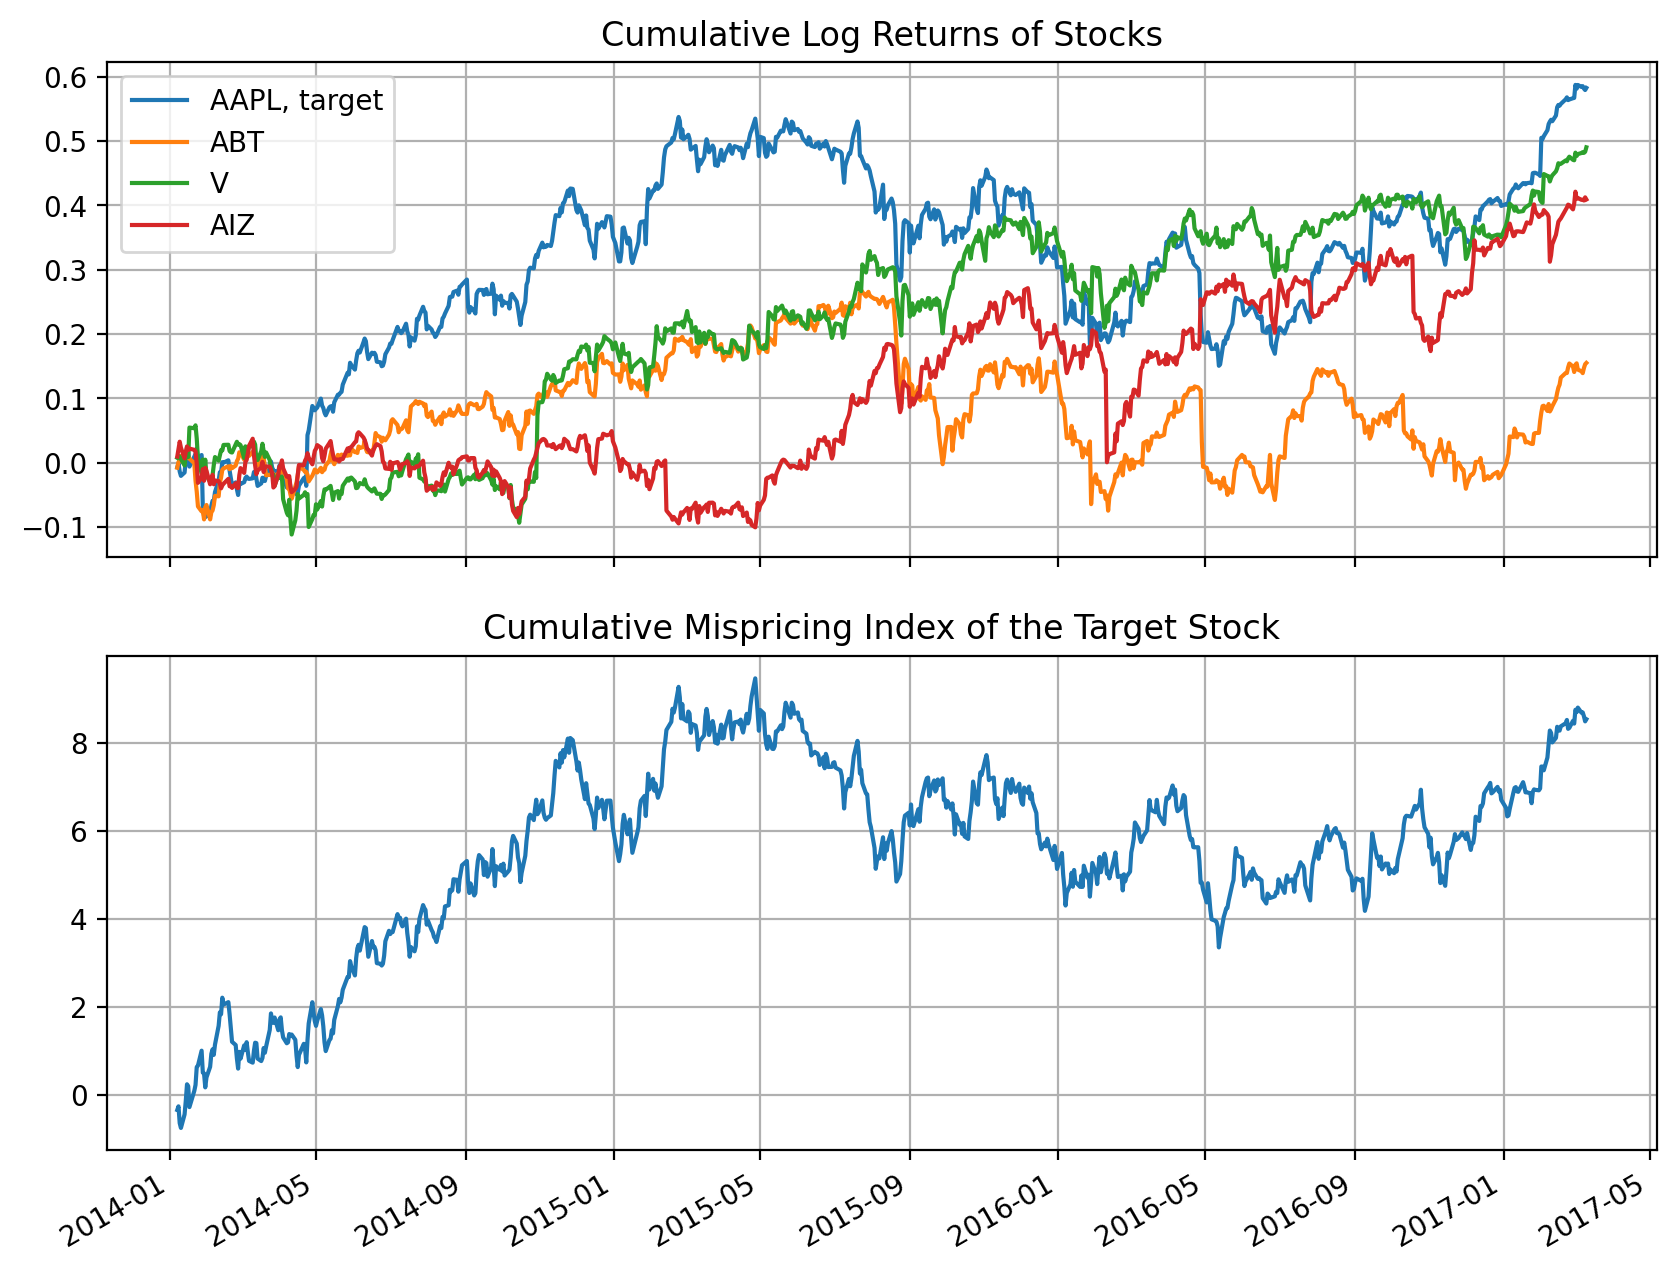

In [5]:
# Plot the cmpis against the log prices for the trading period
sum_log_returns = (returns_test + 1).apply(np.log, axis=0).cumsum()

fig, axs = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 1]}, figsize=(10,8), dpi=200)

axs[0].set_title('Cumulative Log Returns of Stocks')
axs[0].plot(sum_log_returns['AAPL'], label='AAPL, target')
axs[0].plot(sum_log_returns['ABT'], label='ABT')
axs[0].plot(sum_log_returns['V'], label='V')
axs[0].plot(sum_log_returns['AIZ'], label='AIZ')
axs[0].grid()
axs[0].legend()

axs[1].set_title('Cumulative Mispricing Index of the Target Stock')
axs[1].plot(cmpis_trading, label='CMPI')
axs[1].grid()

fig.autofmt_xdate()

plt.show()

In [35]:
positions, bollinger_band = CVCS.get_positions_bollinger(
    returns=returns_test, cdfs=cdfs, mpis=mpis_trading, if_return_bollinger_band=True, threshold_std=2)
units = CVCS.positions_to_units_against_index(target_stock_prices=sp500_prices['AAPL'][800:1600],
                                              index_prices=sp500_prices['SPY'][800:1600],
                                              positions=positions.shift(1))

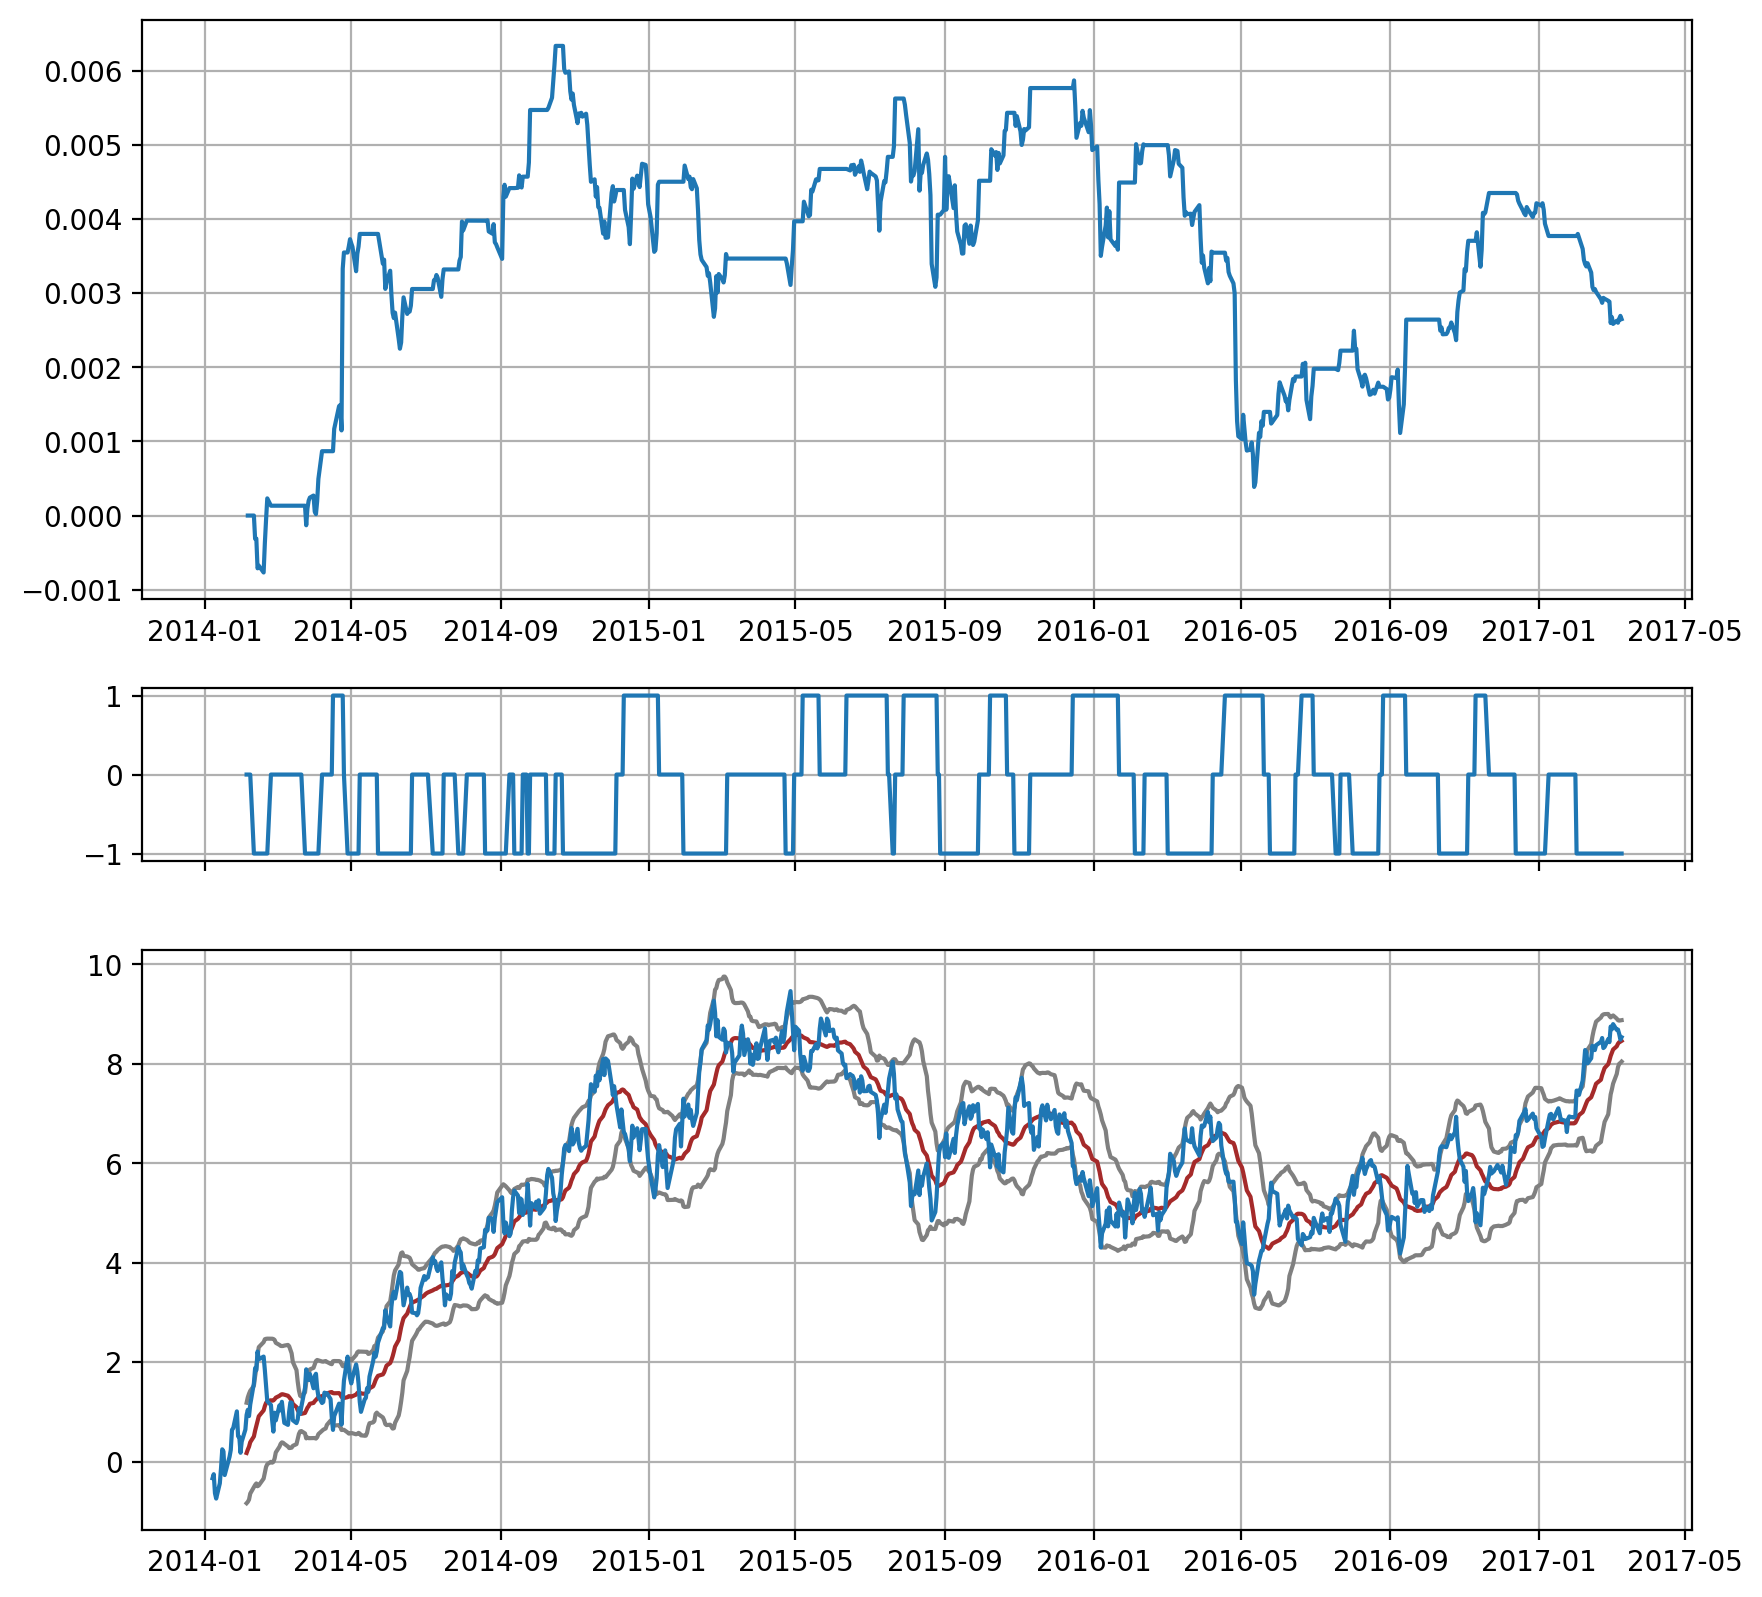

In [36]:
portfolio_pnl = returns_test['AAPL'] * units['AAPL'] + sp500_returns['SPY'][800:1600] * units['SPY']
equity = portfolio_pnl.cumsum()

fig, axs = plt.subplots(3, 1, gridspec_kw={'height_ratios': [1, 0.3, 1]}, sharex=True,
                        figsize=(10,10), dpi=200)

axs[0].plot(equity, label='Equity Curve')
axs[0].grid()
axs[0].xaxis.set_tick_params(which='both', labelbottom=True)

axs[1].plot(positions)
axs[1].grid()

axs[2].plot(bollinger_band['LowerBound'], color='grey')
axs[2].plot(bollinger_band['Mean'], color='brown')
axs[2].plot(bollinger_band['UpperBound'], color='grey')

axs[2].plot(cmpis_trading)
axs[2].grid()

plt.show()

In [20]:
bollinger_band

,LowerBound,Mean,UpperBound
Date,,,
2014-01-07,NaN,NaN,NaN
2014-01-08,NaN,NaN,NaN
2014-01-09,NaN,NaN,NaN
2014-01-10,NaN,NaN,NaN
2014-01-13,NaN,NaN,NaN
...,...,...,...
2017-03-06,7.930360,8.347697,8.765035
2017-03-07,8.044610,8.398863,8.753115
2017-03-08,8.105316,8.430368,8.755419
